# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 2.9MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy

import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc',
 'question_pair',
 'songys-chat']

In [ ]:
sychat_dir = os.path.join(data_dir, "songys-chat")
if not os.path.isdir(sychat_dir):
    os.makedirs(sychat_dir)
os.listdir(sychat_dir)

['lstm.hdf5', 'lstm.csv', 'lstm_dot.csv', 'lstm_dot.hdf5']

# Tutorial

In [ ]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '네가 기분이 좋으니 나도 좋아'], # 앞은 사용자의 말, 뒤는 챗봇이 나와야되는말
    ['나는 오늘 행복해', '나도 행복하다'],
]

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())
print(words)

# 중복 단어 제거
words = list(dict.fromkeys(words))
print(words)

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)
print(word_to_id)
print(word_to_id.items())
# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()} # id하고 word를 ㄹ바꿔주는거지
                                                            # dictionary로 바꿔주고
print(id_to_word)


# word_to_id, id_to_word

['나는', '오늘', '기분이', '좋아', '네가', '기분이', '좋으니', '나도', '좋아', '나는', '오늘', '행복해', '나도', '행복하다']
['나는', '오늘', '기분이', '좋아', '네가', '좋으니', '나도', '행복해', '행복하다']
{'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3, '나는': 4, '오늘': 5, '기분이': 6, '좋아': 7, '네가': 8, '좋으니': 9, '나도': 10, '행복해': 11, '행복하다': 12}
dict_items([('[PAD]', 0), ('[UNK]', 1), ('[BOS]', 2), ('[EOS]', 3), ('나는', 4), ('오늘', 5), ('기분이', 6), ('좋아', 7), ('네가', 8), ('좋으니', 9), ('나도', 10), ('행복해', 11), ('행복하다', 12)])
{0: '[PAD]', 1: '[UNK]', 2: '[BOS]', 3: '[EOS]', 4: '나는', 5: '오늘', 6: '기분이', 7: '좋아', 8: '네가', 9: '좋으니', 10: '나도', 11: '행복해', 12: '행복하다'}


In [ ]:
# train source, target 데이터 생성
train_src_ids, tarin_tgt_ids = [], [] 
for pair in sentences:
    # train_src_ids.append([word_to_id[word] for word in pair[0].split()])
    train_src_ids.append([word for word in pair[0].split()])
    # tarin_tgt_ids.append([word_to_id[word] for word in pair[1].split()])
    tarin_tgt_ids.append([word for word in pair[1].split()])

print(train_src_ids)
print(tarin_tgt_ids)



[['나는', '오늘', '기분이', '좋아'], ['나는', '오늘', '행복해']]
[['네가', '기분이', '좋으니', '나도', '좋아'], ['나도', '행복하다']]


In [ ]:
# 근데 학습은 숫자니까 숫자로 다시
# train source, target 데이터 생성
train_src_ids, tarin_tgt_ids = [], [] 
for pair in sentences:
    train_src_ids.append([word_to_id[word] for word in pair[0].split()])
    # train_src_ids.append([word for word in pair[0].split()])
    tarin_tgt_ids.append([word_to_id[word] for word in pair[1].split()])
    # tarin_tgt_ids.append([word for word in pair[1].split()])

print(train_src_ids)
print(tarin_tgt_ids)


[[4, 5, 6, 7], [4, 5, 11]]
[[8, 6, 9, 10, 7], [10, 12]]


In [ ]:
# train enc_inputs, dec_inputs, dec_label 생성
# encoder input, decoder input, decoder label 3개의 input이 필요

train_enc_inputs, train_dec_inputs, train_dec_labels = [], [], []
for source_id, target_id in zip(train_src_ids, tarin_tgt_ids):
    train_enc_inputs.append(source_id)
    train_dec_inputs.append([word_to_id['[BOS]']] + target_id) # decoder input에는 bos들어가야지
    train_dec_labels.append(target_id + [word_to_id['[EOS]']]) # decodr output에는 eos 들어가고
train_enc_inputs, train_dec_inputs, train_dec_labels

([[4, 5, 6, 7], [4, 5, 11]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3]])

In [ ]:
# encoder의 길이는 달라도됨!
# decoder만 고려! ( input, output)

# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_inputs:
    row += [0] * (6 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_labels:
    row += [0] * (6 - len(row))

train_enc_inputs, train_dec_inputs, train_dec_labels

([[4, 5, 6, 7], [4, 5, 11, 0]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12, 0, 0, 0]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3, 0, 0, 0]])

In [ ]:
# numpy array로 변환
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_dec_labels = np.array(train_dec_labels)

train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[ 4,  5,  6,  7],
        [ 4,  5, 11,  0]]), array([[ 2,  8,  6,  9, 10,  7],
        [ 2, 10, 12,  0,  0,  0]]), array([[ 8,  6,  9, 10,  7,  3],
        [10, 12,  3,  0,  0,  0]]))

In [ ]:
# 단어를 벡터로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 4) # hiddens layer의 size가 4인거지

In [ ]:
# encoder inputs 단어 벡터
enc_hidden = embedding(train_enc_inputs)  # (bs, n_seq, 4)
enc_hidden

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ]],

       [[ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.01447895, -0.01838874,  0.04926274,  0.02590281],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716]]],
      dtype=float32)>

In [ ]:
# encoder LSTM
enc_lstm = tf.keras.layers.LSTM(units=5, return_state=True)

# 마지막 lstm의 state를 뽑아야지!

In [ ]:
# encoder LSTM 실행
enc_hidden, enc_h_state, enc_c_state = enc_lstm(enc_hidden) # (bs,units),(bs,units),(bs,units)
enc_hidden, enc_h_state, enc_c_state

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-0.00082123, -0.00522853, -0.0018438 , -0.00625095, -0.00216456],
        [ 0.00559843, -0.00374473,  0.00191227, -0.00659619,  0.00712104]],
       dtype=float32)>, <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-0.00082123, -0.00522853, -0.0018438 , -0.00625095, -0.00216456],
        [ 0.00559843, -0.00374473,  0.00191227, -0.00659619,  0.00712104]],
       dtype=float32)>, <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-0.00164527, -0.01057572, -0.00372739, -0.01243457, -0.00428837],
        [ 0.01112364, -0.00752604,  0.00385827, -0.0132431 ,  0.01415311]],
       dtype=float32)>)

In [ ]:
# decoder inputs 단어 벡터도 embedding해야지!

dec_hidden = embedding(train_dec_inputs)  # (bs, n_seq, 4) # (bs, decoder sequence , unit)
dec_hidden

<tf.Tensor: shape=(2, 6, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [-0.01826397, -0.03069841,  0.03251565,  0.00923193],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292],
        [-0.01256046,  0.0343336 , -0.02595751,  0.03221213],
        [-0.03375109, -0.02327753, -0.00871272,  0.00912046],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ]],

       [[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [-0.03375109, -0.02327753, -0.00871272,  0.00912046],
        [-0.00891924, -0.02965369, -0.00554544, -0.04765527],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716]]],
      dtype=float32)>

In [ ]:
# decoder LSTM
dec_lstm = tf.keras.layers.LSTM(units=5, return_sequences=True)

# 여기서는 각 단어에 대해서 output이랑 매칭을 해야지!
# 그래서 이번엔s return_Sequences = True한거야!

In [ ]:
# decoder LSTM 실행
dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state]) # 초기값을 encoder의 hiddend이랑 cell의 state로 해준거지!
dec_hidden

<tf.Tensor: shape=(2, 6, 5), dtype=float32, numpy=
array([[[-0.00249466, -0.00307995, -0.00327494, -0.00725163,
         -0.00462817],
        [-0.00511247,  0.00286553, -0.00707264, -0.0032672 ,
         -0.00169703],
        [-0.00767548,  0.00277027, -0.00691308, -0.00053027,
          0.00276191],
        [-0.00805463, -0.00475023, -0.0011885 ,  0.00294018,
          0.00863971],
        [-0.00565409, -0.00261588, -0.00060706,  0.00615305,
          0.01086101],
        [ 0.00350298,  0.00040876,  0.00140416,  0.00345753,
          0.0058279 ]],

       [[ 0.00139186, -0.00246246,  0.00072242, -0.00765236,
          0.00218469],
        [ 0.00048451, -0.00028243,  0.00063642, -0.00177618,
          0.00576928],
        [ 0.00671119,  0.00474663, -0.00099277, -0.00274028,
         -0.00089224],
        [ 0.00684098,  0.0068049 , -0.00256293, -0.00404436,
         -0.00430561],
        [ 0.00700419,  0.00854143, -0.0040837 , -0.00513258,
         -0.00682055],
        [ 0.00714516,  

In [ ]:
# 다음단어 예측 layer
linear = tf.keras.layers.Dense(len(word_to_id), activation=tf.nn.softmax)

In [ ]:
# 다음단어 예측 실행
y_pred = linear(dec_hidden)
y_pred
# 다음 단어를 예측한 확률 분포를 나타낸거지

<tf.Tensor: shape=(2, 6, 13), dtype=float32, numpy=
array([[[0.07716898, 0.07661305, 0.07664085, 0.07680578, 0.07687765,
         0.07710789, 0.07645434, 0.07708682, 0.07674611, 0.07692434,
         0.07732236, 0.07680716, 0.07744462],
        [0.07708991, 0.07633257, 0.07666312, 0.07673548, 0.07697012,
         0.07704493, 0.07661941, 0.07711019, 0.07692874, 0.07712539,
         0.07735518, 0.07677006, 0.07725497],
        [0.07718163, 0.07624134, 0.07670059, 0.07662452, 0.07713697,
         0.07705553, 0.07661742, 0.0769958 , 0.07691862, 0.07714893,
         0.07736775, 0.07677548, 0.07723553],
        [0.07740643, 0.07661386, 0.07679015, 0.07650935, 0.07729886,
         0.07711311, 0.07660066, 0.07663357, 0.07675718, 0.07688096,
         0.07722329, 0.07688156, 0.077291  ],
        [0.07727183, 0.07674201, 0.07694732, 0.07661077, 0.07727483,
         0.07700405, 0.07685293, 0.07651459, 0.07691538, 0.07688915,
         0.07700407, 0.07696856, 0.07700453],
        [0.07687404, 0.07705

In [ ]:
train_dec_labels

array([[ 8,  6,  9, 10,  7,  3],
       [10, 12,  3,  0,  0,  0]])

In [ ]:
# CE loss
tf.keras.losses.SparseCategoricalCrossentropy()(train_dec_labels, y_pred)

# 실제 label을 one-hot-vector로 바꿔서 crossentropy까지 계산해주는걸 한번에 해주는거지

<tf.Tensor: shape=(), dtype=float32, numpy=2.56618>

In [ ]:
train_dec_labels

array([[ 8,  6,  9, 10,  7,  3],
       [10, 12,  3,  0,  0,  0]])

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args

Namespace(d_model=32, n_vocab=13, seed=1234)

In [ ]:
def build_model(args):
    enc_inputs = tf.keras.layers.Input((None,), name="enc_inputs")  # (bs, n_enc_seq)
    dec_inputs = tf.keras.layers.Input((None,), name="dec_inputs")  # (bs, n_dec_seq)
    ################################
    # Embedding
    ################################
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    enc_hidden = embedding(enc_inputs)  # (bs, n_enc_seq, d_model)
    dec_hidden = embedding(dec_inputs)  # (bs, n_dec_seq, d_model)
    ################################
    # Encoder
    ################################
    enc_lstm = tf.keras.layers.LSTM(units=args.d_model, return_state=True, name="enc_lstm")
    enc_hidden, enc_h_state, enc_c_state = enc_lstm(enc_hidden) # (bs,units),(bs,units),(bs,units)
    ################################
    # Decoder
    ################################
    dec_lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, name="dec_lstm")
    dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state]) # (bs,n_dec_seq,units) # encoding의 input size랑 decoding의 input size는 다르니까 신경쓴거지!
    ################################
    # Next word prediction
    ################################
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(dec_hidden) # (bs,n_dec_seq, n_vocab)
    ################################
    # Model
    ################################
    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

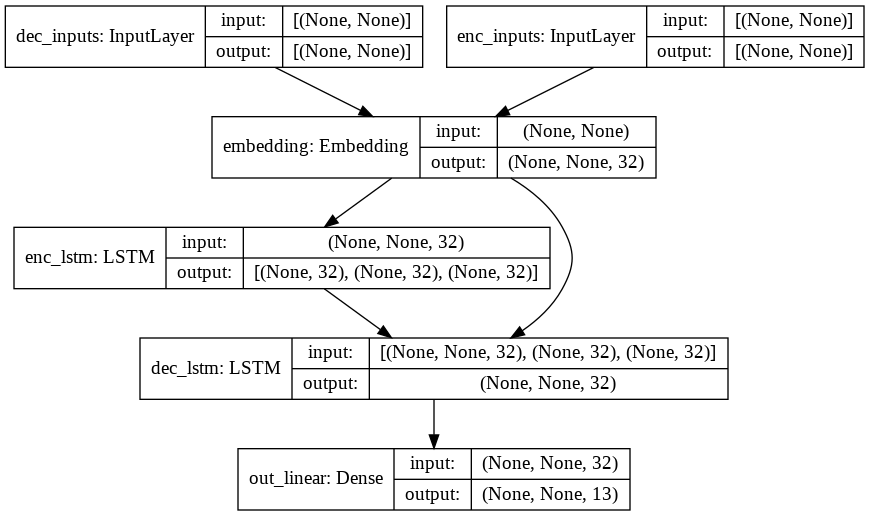

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs[:4], train_dec_inputs[:4]))

array([[[0.07669406, 0.0775681 , 0.07841668, 0.07774511, 0.07592772,
         0.07592671, 0.07651905, 0.07630295, 0.07631198, 0.07770398,
         0.07634444, 0.07688932, 0.07764991],
        [0.07621206, 0.07743   , 0.07751198, 0.077186  , 0.07684258,
         0.07621063, 0.07682218, 0.0764806 , 0.07627117, 0.07767154,
         0.07674176, 0.07715047, 0.07746906],
        [0.07598892, 0.07785373, 0.07687035, 0.07758692, 0.07719386,
         0.07609461, 0.07720447, 0.07734662, 0.07655492, 0.07611506,
         0.07648488, 0.07717209, 0.0775336 ],
        [0.07662675, 0.07782743, 0.07643627, 0.07771534, 0.07682704,
         0.07663181, 0.07699468, 0.07758946, 0.07679745, 0.07601063,
         0.07722942, 0.07666283, 0.07665085],
        [0.07663194, 0.07811173, 0.07691   , 0.07660309, 0.07662018,
         0.07641372, 0.07684214, 0.07735501, 0.07614087, 0.07601038,
         0.07704445, 0.07738463, 0.07793189],
        [0.07657768, 0.07768619, 0.0766004 , 0.07722843, 0.07729631,
         0.

# Vocabulary*

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

# Data*

In [ ]:
# 파일 다운로드 및 목록 확인
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
os.listdir('./')

# label은 안쓸거고 q, a만 쓸거ㅣㅁ

--2021-05-28 10:03:47--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-05-28 10:03:48--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv’

ChatbotData .csv    100%[===================>] 868.99K  --.-KB/s    in 0.1s    

2021-05-28 10:03:48 (6.52 MB/s) - ‘ChatbotData .csv’ saved [889842/889842]



['.config', 'model.png', 'drive', 'ChatbotData .csv', 'sample_data']

In [ ]:
# 파일명 변경 및 목록 확인
!mv 'ChatbotData .csv' ChatbotData.csv # 파일명의 공백을 공백 없이 바꿔라!
os.listdir('./')

['.config', 'model.png', 'ChatbotData.csv', 'drive', 'sample_data']

# Loss & Acc*

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

    # 여기서는 padding을 빼는 방법이지?

In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

    # 마찬가지로 accuracy도 padding을 뺀채로 해주는거제?

# Small Data Project

## Train 데이터 생성

In [ ]:
# data load
df_train = pd.read_csv('ChatbotData.csv')
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# null 제거
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# Q 길이
q_length = df_train["Q"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
q_length.head(10), q_length.max()

(0     5
 1     6
 2     9
 3    10
 4     5
 5     7
 6     5
 7     7
 8    11
 9     9
 Name: Q, dtype: int64, 27)

In [ ]:
# A 길이
a_length = df_train["A"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
a_length.head(10), a_length.max()

(0    6
 1    6
 2    6
 3    6
 4    9
 5    9
 6    9
 7    7
 8    6
 9    6
 Name: A, dtype: int64, 39)

In [ ]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

,Q,A,label
11761,하루종일 썸남 생각만 해. 괜찮을까?,그것 또한 감정의 일부니까요.,2
924,냉장고에 먹을 게 하나도 없네,슈퍼라도 가서 쇼핑하고 오세요.,0
3763,인사드리러 갔는데 파혼하는게 나을것 같아,이혼이 아니라 다행입니다.,0
341,금값 어때,비싸요.,0
10736,연애상담하더니 둘이 사귀더라,대화를 하다가 친해졌나봐요.,2
5140,혼자 노래방 가면 어색할 거 같은데,신나는 노래로 분위기를 띄어보세요.,0
5713,기회도 없네.,다른 기회가 올 거예요.,1
9996,사랑한 만큼 배려해야했어,이제야 깨달았나봐요.,2
3168,여자친구가 전화를 안해,다른 연락을 많이 하거나 더 자주 만나세요.,0
9762,못생긴 남자를 좋아하는 여자가 있을지.,외모가 중요한 시대는 끝났어요.,2


In [ ]:
def make_data(df, vocab, n_enc_seq, n_dec_seq): # data를 3개를 만들어야함
    """
    chat 학습 데이터 생성
    :param df: data frame
    :param df: vocab
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return dec_labels: decoder label data
    """
    
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1  # [BOS] or [EOS]
    # inputa & labels
    enc_inputs = []
    dec_inputs = []
    dec_labels = []
    # 데이터 생성
    for i, row in tqdm(df.iterrows(), total=len(df)):
        Q = row['Q']
        A = row['A']
        # print(Q, '/', A)
        # tokenize
        tokens_q = vocab.encode_as_ids(Q)
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_ids(A)
        # print(len(tokens_a), ':', tokens_a)
        # 최대 길이로 자르기
        tokens_q = tokens_q[:n_enc_max]
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = tokens_a[:n_dec_max]
        # print(len(tokens_a), ':', tokens_a)
        # input & label 정의
        enc_input = tokens_q
        # print(len(enc_input), ':', enc_input)
        dec_input = [vocab.bos_id()] + tokens_a
        # print(len(dec_input), ':', dec_input)
        dec_label = tokens_a + [vocab.eos_id()]
        # print(len(dec_label), ':', dec_label)
        # pad 추가
        enc_input += [0] * (n_enc_seq - len(enc_input))
        # print(len(enc_input), ':', enc_input)
        dec_input += [0] * (n_dec_seq - len(dec_input))
        # print(len(dec_input), ':', dec_input)
        dec_label += [0] * (n_dec_seq - len(dec_label))
        # print(len(dec_label), ':', dec_label)
        # 값 저장
        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_labels.append(dec_label)
    # to numpy array
    enc_inputs = np.array(enc_inputs)
    dec_inputs = np.array(dec_inputs)
    dec_labels = np.array(dec_labels)
    return enc_inputs, dec_inputs, dec_labels

In [ ]:
train_enc_inputs, train_dec_inputs, train_dec_labels = make_data(df_train, vocab, 27, 40)
train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[ 2424,   378,    30,    10, 27556,   486,  1028,    59,   209,
             7,    10, 31855, 14969,    11,  3083,  2138,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 6740,   159,    37,    14,  9956,  1717,   477,    32,  5639,
           377,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 2482,  6720,   479, 10227,   680,   522,  2193,    42,    87,
           349,    11,  6119, 14380,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  653,  3441,   542,  1433,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 7479,   128,  1119,   277, 10922,  1687,    20, 19010,   576,
           105,     0,     0,     0,     0,     0,     0,   

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args

Namespace(d_model=256, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    enc_inputs = tf.keras.layers.Input((None,), name="enc_inputs")  # (bs, n_enc_seq)
    dec_inputs = tf.keras.layers.Input((None,), name="dec_inputs")  # (bs, n_dec_seq)
    ################################
    # Embedding
    ################################
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    enc_hidden = embedding(enc_inputs)  # (bs, n_enc_seq, d_model)
    dec_hidden = embedding(dec_inputs)  # (bs, n_dec_seq, d_model)
    ################################
    # Encoder
    ################################
    enc_lstm = tf.keras.layers.LSTM(units=args.d_model, return_state=True, name="enc_lstm")
    enc_hidden, enc_h_state, enc_c_state = enc_lstm(enc_hidden)
    # _, enc_h_state, enc_c_state = enc_lstm(enc_hidden) 안쓰면 이렇게 변수명 막으면됨
    ################################
    # Decoder
    ################################
    dec_lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, name="dec_lstm")
    dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])
    ################################
    # Next word prediction
    ################################
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(dec_hidden)
    ################################
    # Model
    ################################
    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

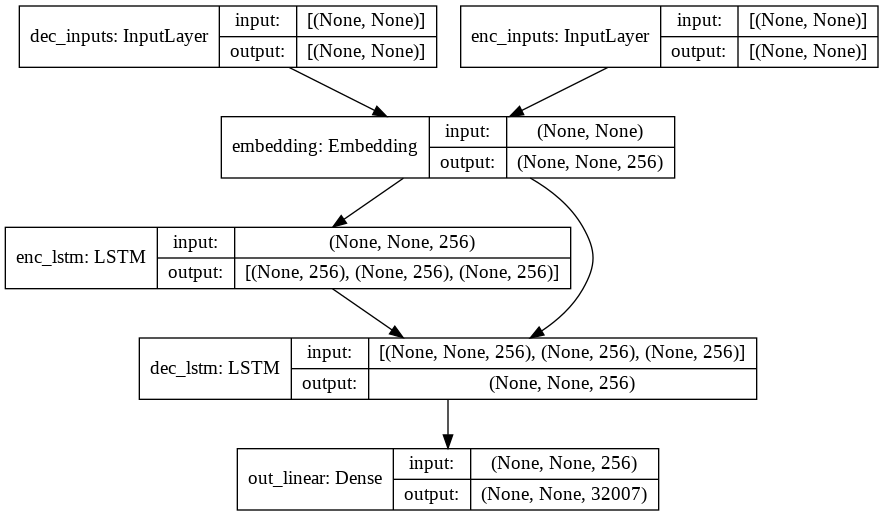

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs[:4], train_dec_inputs[:4]))

array([[[3.1187854e-05, 3.1203606e-05, 3.1298761e-05, ...,
         3.1258249e-05, 3.1166532e-05, 3.1246782e-05],
        [3.1158328e-05, 3.1231215e-05, 3.1320258e-05, ...,
         3.1286898e-05, 3.1214571e-05, 3.1255229e-05],
        [3.1185598e-05, 3.1251911e-05, 3.1322190e-05, ...,
         3.1294341e-05, 3.1200583e-05, 3.1282023e-05],
        ...,
        [3.1357238e-05, 3.1162916e-05, 3.1342461e-05, ...,
         3.1220839e-05, 3.1220727e-05, 3.1311716e-05],
        [3.1357209e-05, 3.1162850e-05, 3.1342457e-05, ...,
         3.1220945e-05, 3.1220748e-05, 3.1311643e-05],
        [3.1357191e-05, 3.1162799e-05, 3.1342453e-05, ...,
         3.1221032e-05, 3.1220767e-05, 3.1311574e-05]],

       [[3.1176463e-05, 3.1202482e-05, 3.1300657e-05, ...,
         3.1263091e-05, 3.1170843e-05, 3.1243861e-05],
        [3.1188596e-05, 3.1225813e-05, 3.1260563e-05, ...,
         3.1275747e-05, 3.1176016e-05, 3.1233089e-05],
        [3.1177660e-05, 3.1241907e-05, 3.1264852e-05, ...,
         3.129

## Train

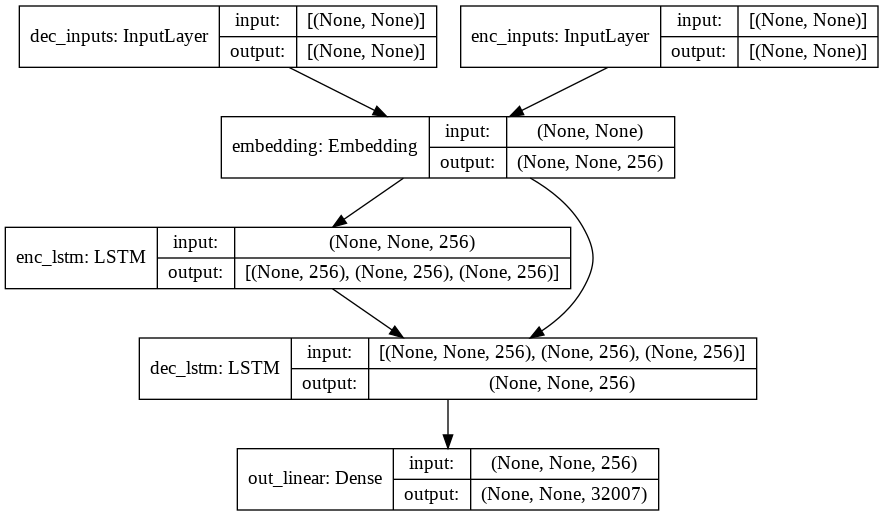

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=30)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(sychat_dir, "lstm.hdf5"), # 채팅 디렉토리안에 lstm이란 이름으로 저장
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(sychat_dir, "lstm.csv"))

In [ ]:
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_dec_labels,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 2.3860 - lm_acc: 0.0000e+00

Epoch 00001: lm_acc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 2/100
1/1 [==============================] - 1s 816ms/step - loss: 2.3849 - lm_acc: 0.1304

Epoch 00002: lm_acc improved from 0.00000 to 0.13043, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 3/100
1/1 [==============================] - 1s 820ms/step - loss: 2.3836 - lm_acc: 0.2500

Epoch 00003: lm_acc improved from 0.13043 to 0.25000, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 4/100
1/1 [==============================] - 1s 796ms/step - loss: 2.3817 - lm_acc: 0.2391

Epoch 00004: lm_acc did not improve from 0.25000
Epoch 5/100
1/1 [==============================] - 1s 783ms/step - loss: 2.3784 - lm_acc: 0.2609

Epoch 00005: lm_acc

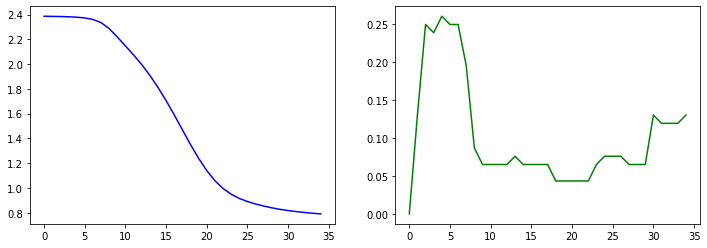

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')

plt.show()

## BLEU

In [ ]:
candidate = 'the the the the the the the'.split()
references = [
    'the cat is on the mat'.split(),
    'there is a cat on the mat'.split()
]

In [ ]:
candidate, references

(['the', 'the', 'the', 'the', 'the', 'the', 'the'],
 [['the', 'cat', 'is', 'on', 'the', 'mat'],
  ['there', 'is', 'a', 'cat', 'on', 'the', 'mat']])

In [ ]:
a = collections.defaultdict(int) # 없는 값이 나오면 초기값을 제공함!
a['c']
a['d']
a

defaultdict(int, {'c': 0, 'd': 0})

In [ ]:
b = {} # 기본 딕셔너리는 오류가 걸리지만
b

{}

In [ ]:
def get_ngram(tokens, ngram):
    # tokens n-gram
    counter = collections.defaultdict(int)
    # print(counter)
    for i in range(len(tokens) - ngram + 1):
        # n-gram 별 count
        key = tuple(tokens[i:i+ngram])
        # print(key)
        counter[key] += 1
        print(i, key, counter)
    return  counter

In [ ]:
get_ngram(candidate, 1)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('the',) defaultdict(<class 'int'>, {('the',): 2})
2 ('the',) defaultdict(<class 'int'>, {('the',): 3})
3 ('the',) defaultdict(<class 'int'>, {('the',): 4})
4 ('the',) defaultdict(<class 'int'>, {('the',): 5})
5 ('the',) defaultdict(<class 'int'>, {('the',): 6})
6 ('the',) defaultdict(<class 'int'>, {('the',): 7})


defaultdict(int, {('the',): 7})

In [ ]:
get_ngram(candidate, 2)

0 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 1})
1 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 2})
2 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 3})
3 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 4})
4 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 5})
5 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 6})


defaultdict(int, {('the', 'the'): 6})

In [ ]:
get_ngram(candidate, 3)

0 ('the', 'the', 'the') defaultdict(<class 'int'>, {('the', 'the', 'the'): 1})
1 ('the', 'the', 'the') defaultdict(<class 'int'>, {('the', 'the', 'the'): 2})
2 ('the', 'the', 'the') defaultdict(<class 'int'>, {('the', 'the', 'the'): 3})
3 ('the', 'the', 'the') defaultdict(<class 'int'>, {('the', 'the', 'the'): 4})
4 ('the', 'the', 'the') defaultdict(<class 'int'>, {('the', 'the', 'the'): 5})


defaultdict(int, {('the', 'the', 'the'): 5})

In [ ]:
# cliping = 래퍼런스의 max값


def get_ngram_clip(candidate, references, ngram):
    # max ref counter
    max_counter = collections.defaultdict(int)
    # check max count
    for ref in references: # 래퍼런스가 여러개니까
        ref_counter = get_ngram(ref, ngram)
        print(ref)
        print(ref_counter) # dict으로 중복없이, 중복된거는 count해주고

        for key, cnt in ref_counter.items():
            max_counter[key] = max(max_counter[key], ref_counter.get(key, 0)) # none이 있을때 get함수를 통해 0으로 줘라!
            print(key, ref_counter.get)

    # candidate counter
    can_counter = get_ngram(candidate, ngram)
    # print(max_counter)
    # print(can_counter)

    # 위에 max count랑 ,candidate counter 구했으니까 min값 구해야지
    # clip counter 그 2개의 minimum값을 구하는거지

    clip_counter = collections.defaultdict(int)
    for key, cnt in can_counter.items():
        clip_counter[key] = min(can_counter[key], max_counter.get(key, 0)) 
    return clip_counter

In [ ]:
get_ngram_clip(candidate, references, 1)

['the', 'cat', 'is', 'on', 'the', 'mat']
defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
['there', 'is', 'a', 'cat', 'on', 'the', 'mat']
defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1, ('mat',): 1})
defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1, ('there',): 1, ('a',): 1})


In [ ]:
# FP/TP + FP => positive 예측중에 정답 비율

def get_ngram_precision(candidate, references, ngram):
    # clip counter
    clip_counter = get_ngram_clip(candidate, references, ngram) 
    print(clip_counter)
    n_clip = sum(clip_counter.values())
    print(n_clip)

    # ref counter
    can_counter = get_ngram(candidate, ngram)
    print(can_counter)
    n_total = sum(can_counter.values())

    return n_clip / max(n_total, 1)  # 분모 0 방지

In [ ]:
get_ngram_precision(candidate, references, 1)

defaultdict(<class 'int'>, {})
('the',)
('cat',)
('is',)
('on',)
('the',)
('mat',)
['the', 'cat', 'is', 'on', 'the', 'mat']
defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
defaultdict(<class 'int'>, {})
('there',)
('is',)
('a',)
('cat',)
('on',)
('the',)
('mat',)
['there', 'is', 'a', 'cat', 'on', 'the', 'mat']
defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1, ('mat',): 1})
defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1, ('there',): 1, ('a',): 1})
defaultdict(<class 'int'>, {})
('the',)
('the',)
('the',)
('the',)
('the',)
('the',)
('the',)
defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1, ('there',): 1, ('a',): 1})
defaultdict(<class 'int'>, {('the',): 7})
defaultdict(<class 'int'>, {('the',): 2})
2
defaultdict(<class

0.2857142857142857

In [ ]:
def get_brevity_penalty(candidate, references):
    can_len = len(candidate)
    ref_len = min([len(reference) for reference in references])

    if can_len == 0:  # empty string
        return 0
    elif can_len > ref_len:
        return 1
    else:
        return np.exp(1 - ref_len / can_len)

In [ ]:
get_brevity_penalty(candidate, references)

1

In [ ]:
def get_bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = get_brevity_penalty(candidate, references) # BP
    p_n = []
    for i in range(len(weights)):
        p_n.append(get_ngram_precision(candidate, references, i + 1))
    score = [w * np.log(p) if p != 0 else 0 for p, w in zip(p_n, weights)]
    score = np.sum(score)
    score = bp * np.exp(score)
    return score

In [ ]:
get_bleu_score(candidate, references)

0.7311104457090247

In [ ]:
import nltk.translate.bleu_score as bleu
from nltk import ngrams

In [ ]:
bleu.sentence_bleu(references, candidate)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7311104457090247

In [ ]:
candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'.split()
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands'.split(),
    'It is the guiding principle which guarantees the military forces always being under the command of the Party'.split(),
    'It is the practical guide for the army always to heed the directions of the party'.split()
]

In [ ]:
get_bleu_score(candidate, references)

0.5045666840058485

In [ ]:
bleu.sentence_bleu(references, candidate)

0.5045666840058485

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm.hdf5"))

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
# 100개만 확인
valid_enc_inputs = train_enc_inputs[:100]
valid_dec_inputs = train_dec_inputs[:100]
valid_dec_labels = train_dec_labels[:100]

In [ ]:
# 평가
model.evaluate((valid_enc_inputs, valid_dec_inputs), valid_dec_labels, batch_size=128)

1/1 [==============================] - 1s 1s/step - loss: 2.3758 - lm_acc: 0.2174


[2.3757660388946533, 0.21739129722118378]

In [ ]:
references = []
for row in valid_dec_labels:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    references.append(string)
references

[['▁그것', '▁또한', '▁감정', '의', '▁일부', '니까', '요', '.'],
 ['▁슈퍼', '라도', '▁가서', '▁쇼핑', '하고', '▁오', '세요', '.'],
 ['▁이혼', '이', '▁아니라', '▁다', '행', '입니다', '.'],
 ['▁비싸', '요', '.'],
 ['▁대화', '를', '▁하다가', '▁친', '해', '졌', '나', '봐', '요', '.'],
 ['▁신', '나', '는', '▁노래로', '▁분위기', '를', '▁', '띄', '어', '보', '세요', '.'],
 ['▁다른', '▁기회', '가', '▁올', '▁거', '예', '요', '.'],
 ['▁이제', '야', '▁깨달았', '나', '봐', '요', '.'],
 ['▁다른', '▁연락', '을', '▁많이', '▁하거나', '▁더', '▁자주', '▁만나', '세요', '.'],
 ['▁외모', '가', '▁중요한', '▁시대', '는', '▁끝', '났', '어요', '.']]

In [ ]:
# 예측
y_pred = model.predict((valid_enc_inputs, valid_dec_inputs))
y_pred

In [ ]:
# greedy decoding
y_pred_class = tf.argmax(y_pred, axis=-1).numpy()
y_pred_class

In [ ]:
candidates = []
for row in y_pred_class:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    candidates.append(string)
candidates

In [ ]:
bleu_scores = []
for reference, candidate in zip(references, candidates):
    bleu_score = bleu.sentence_bleu([reference], candidate)
    bleu_scores.append(bleu_score)
    print(bleu_score, ":", reference, "/", candidate)
np.mean(bleu_scores)

## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm.hdf5"))

In [ ]:
def do_chat(vocab, model, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q]

    # answer
    a_id = [vocab.bos_id()]

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        # print(q_id)
        # print(a_id)
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = int(np.argmax(prob))
        # print(word_id)
        if word_id == vocab.eos_id():
            break
        a_id.append(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    # print(predict_id)
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
string = '남에게 피해주지 않는 건 기본이죠.'
do_chat(vocab, model, 40, string)

'슈퍼요.'

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, 40, string)
    print(f'답변 > {predict_str}')

질문 > 너는 누구니
답변 > 이혼 연락요.
질문 > 


# All Data Project